In [1]:
import numpy as np
import scipy

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cbook as cbook
from matplotlib import cm
    
from datetime import datetime
import time

In [8]:
class OrthogonalCollocations:
    
    def __init__(self, V_0, R, M):
        self.V_0 = V_0
        self.R = R
        self.M = M
        
        # grid points
        self.x = np.linspace(-R, R, M+1)
        self.delta = self.x[1] - self.x[0]
        
        # collocation points
        self.x_c = np.zeros(2*self.M)
        self.x_c[::2] = self.x[:-1] + self.delta/2 * (1 - 1/np.sqrt(3))
        self.x_c[1::2] = self.x[:-1] + self.delta/2 * (1 + 1/np.sqrt(3))
        
    
    def V(self, x):
        return self.V_0 * np.exp(-x**2)
    
    
    # functions in S_{3,2}
    def phi(self, k, x_):
        if x_ > self.x[k] - self.delta and x_ <= self.x[k]:
            return -2/self.delta**3 * (x_-self.x[k])**3 - 3/self.delta**2 * (x_-self.x[k])**2 + 1
        elif x_ > self.x[k] and x_ <= self.x[k] + self.delta:
            return 2/self.delta**3 * (x_-self.x[k])**3 - 3/self.delta**2 * (x_-self.x[k])**2 + 1
        else:
            return 0.0
        
    def psi(self, k, x_):
        if x_ > self.x[k] - self.delta and x_ <= self.x[k]:
            return 1/self.delta**2 * (x_-self.x[k])**3 + 2/self.delta * (x_-self.x[k])**2 + (x_-self.x[k])
        elif x_ > self.x[k] and x_ <= self.x[k] + self.delta:
            return 1/self.delta**2 * (x_-self.x[k])**3 - 2/self.delta * (x_-self.x[k])**2 + (x_-self.x[k])
        else:
            return 0.0
    
    
    # second derivatives of these functions
    def phi_xx(self, k, x_):
        if x_ > self.x[k] - self.delta and x_ <= self.x[k]:
            return -12/self.delta**3 * (x_-self.x[k]) - 6/self.delta**2
        elif x_ > self.x[k] and x_ <= self.x[k] + self.delta:
            return 12/self.delta**3 * (x_-self.x[k]) - 6/self.delta**2
        else:
            return 0.0

        
    def psi_xx(self, k, x_):
        if x_ > self.x[k] - self.delta and x_ <= self.x[k]:
            return 6/self.delta**2 * (x_-self.x[k]) + 4/self.delta
        elif x_ > self.x[k] and x_ <= self.x[k] + self.delta:
            return 6/self.delta**2 * (x_-self.x[k]) - 4/self.delta
        else:
            return 0.0


    # functions that form something like basis in S_{3,2}
    def S(self, l, x_):
        if l == 0 or l == 2*self.M:
            return self.psi(l//2, x_)
        elif l % 2 == 1:
            return self.psi((l+1)//2, x_)
        else:
            return self.phi(l//2, x_)

        
    # and their second derivatives
    def S_xx(self, l, x_):
        if l == 0 or l == 2*self.M:
            return self.psi_xx(l//2, x_)
        elif l % 2 == 1:
            return self.psi_xx((l+1)//2, x_)
        else:
            return self.phi_xx(l//2, x_)
    
    def sqrt_eigvals(self):
        A = np.zeros((2*self.M, 2*self.M))
        B = np.zeros((2*self.M, 2*self.M))

        for l in range(2*self.M):
            for t in range(2*self.M):
                A[l,t] = -self.S_xx(l, self.x_c[t]) + self.V(self.x_c[t]) * self.S(l, self.x_c[t])
                B[l,t] = self.S(l, self.x_c[t])
        
        sqrt_B_inv = scipy.linalg.inv(scipy.linalg.sqrtm(B))
        Mat = sqrt_B_inv @ A @ sqrt_B_inv
        w = np.sort(scipy.linalg.eigvals(Mat))
        return w[(w>self.V_0)*(w<0.0)]
    
    def eigvals(self):
        A = np.zeros((2*self.M, 2*self.M))
        B = np.zeros((2*self.M, 2*self.M))

        for l in range(2*self.M):
            for t in range(2*self.M):
                A[l,t] = -self.S_xx(l, self.x_c[t]) + self.V(self.x_c[t]) * self.S(l, self.x_c[t])
                B[l,t] = self.S(l, self.x_c[t]) 
                
        w, v = scipy.linalg.eig(a=A, b=B)
        w1 = w[(w>self.V_0)*(w<0.0)]
        v = v[(w>self.V_0)*(w<0.0)]
        w = w1
        del w1
        
        residual = [scipy.linalg.norm((A - w[i] * B) @ v[i]) for i in range(len(w))]
        
        return w, residual
    
#     def eigvals(self):
#         A = np.zeros((2*self.M, 2*self.M))
#         B = np.zeros((2*self.M, 2*self.M))

#         for l in range(2*self.M):
#             for t in range(2*self.M):
#                 A[l,t] = -self.S_xx(l, self.x_c[t]) + self.V(self.x_c[t]) * self.S(l, self.x_c[t])
#                 B[l,t] = self.S(l, self.x_c[t]) 

#         Mat = scipy.linalg.inv(B) @ A
        
#         eigvals = np.sort(scipy.linalg.eigvals(Mat))
        
#         return eigvals[(eigvals<0.0)*(eigvals>self.V_0)]

# Task 1

In [3]:
n = np.zeros(100)
v0 = np.linspace(-20.0+1e-2, -1e-2, len(n))

for i in range(len(n)):
    oc = OrthogonalCollocations(v0[i], 20, 300)
    n[i] = len(oc.fast_eigvals())
#     n[i] = len(oc.eigvals())
    if i % 5 == 0: print(i)

0
5


KeyboardInterrupt: 

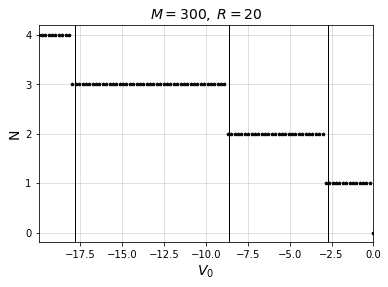

In [9]:
plt.plot(v0, n, linestyle='', marker='p', color='black', ms=3)
plt.axvline(x=-2.684, color='black', linestyle='-', linewidth=1)
plt.axvline(x=-8.650, color='black', linestyle='-', linewidth=1)
plt.axvline(x=-17.796, color='black', linestyle='-', linewidth=1)

plt.xlabel(r'$V_0$', fontsize=14)
plt.ylabel('N', fontsize=14)

plt.title(r'$M=300,\; R=20$', fontsize=14)

plt.yticks([0,1,2,3,4])
plt.xlim(v0[0], 0)

plt.grid(alpha=0.5)

plt.savefig('figures/num_eigen_vs_v0.pdf')

# Task 2

In [102]:
m = np.linspace(10, 500, 20, dtype=int)
t = [None] * len(m)

print('m   t')

for i in range(len(m)):
    start_time = datetime.now()
    
    oc = OrthogonalCollocations(-1, 20, m[i])
    eigvals = oc.fast_eigvals()
    
    t[i] = datetime.now() - start_time
    
    print(m[i],t[i])
    

m   t
10 0:00:00.004859
35 0:00:00.063001
61 0:00:00.116513
87 0:00:00.270936
113 0:00:00.499551
138 0:00:00.685684
164 0:00:00.967204
190 0:00:01.465479
216 0:00:01.850548
242 0:00:02.385549
267 0:00:02.944288
293 0:00:03.892544
319 0:00:04.668142
345 0:00:05.381678
371 0:00:06.478944
396 0:00:07.344680
422 0:00:09.139621
448 0:00:13.694007
474 0:00:12.346847
500 0:00:15.019658


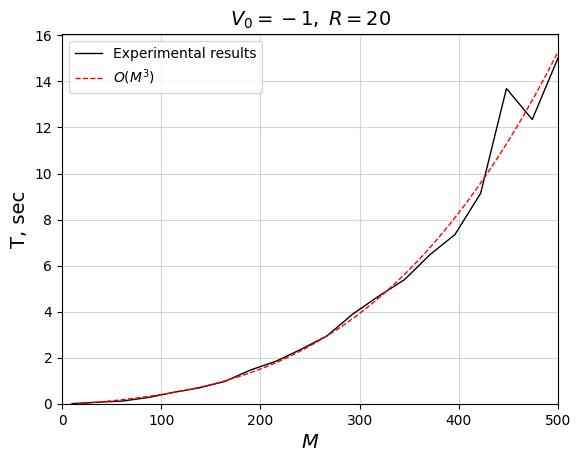

In [105]:
tt = [t_.seconds+t_.microseconds*1e-6 for t_ in t]

p = np.poly1d(np.polyfit(m, tt, 3))
mm = np.linspace(0, m[-1])

plt.plot(m, tt, color='black', linewidth=1, label='Experimental results')

plt.plot(mm, p(mm), color='red', linewidth=1, linestyle='--', label=r'$O(M^3)$')

plt.xlabel(r'$M$', fontsize=14)
plt.ylabel('T, sec', fontsize=14)

plt.title(r'$V_0=-1,\; R=20$', fontsize=14)

plt.xlim(0, m[-1])
plt.ylim(0, None)

plt.grid(alpha=0.5)
plt.legend()

plt.savefig('figures/T_vs_M.pdf', bbox_inches='tight')

# Task 3

In [11]:
N = 5

e0 = np.full((N,N), np.nan)
res = np.full((N,N), np.nan)
r = np.linspace(10, 100, N)
m = np.linspace(10, 500, N, dtype=int)

e_0_true = -0.3539907385825565

for i in range(N):
    for j in range(N):
        oc = OrthogonalCollocations(-1, r[i], m[j])
        eigvals, resid = oc.eigvals()
        if len(eigvals) > 0:
            e0[i,j]= eigvals[0].real
            res[i,j] = resid[0]
        print(i,j, eigvals[:1].real, resid)

0 0 [-0.3928212] [1.969054885981657]
0 1 [-0.35397964] [213.63910760819994]
0 2 [-0.35397973] [791.5362485619347]
0 3 [-0.35397974] [1703.608464196636]
0 4 [-0.35397974] [2917.5158681406397]
1 0 [-0.09165257] [0.5115933083658284]
1 1 [-0.35398219] [19.996893520516064]
1 2 [-0.35399111] [66.24999520719408]
1 3 [-0.3539917] [169.86887557877918]
1 4 [-0.35399181] [288.86703122663863]
2 0 [-0.00028375] [0.21460578165312233]
2 1 [-0.3540383] [8.262647937865033]
2 2 [-0.35398603] [22.282778120961165]
2 3 [-0.35399059] [53.96509123281783]
2 4 [-0.35399144] [99.021489275174]
3 0 [] []
3 1 [-0.3569029] [4.001378619247797]
3 2 [-0.35396963] [12.835476540352023]
3 3 [-0.35398702] [25.960938660425626]
3 4 [-0.35399025] [46.34511153095522]
4 0 [] []
4 1 [-0.36826258] [2.9984922384674464]
4 2 [-0.35388777] [8.246804644683605]
4 3 [-0.35397897] [16.31616885847249]
4 4 [-0.35398751] [25.40000596012639]


In [171]:
e0_pres = np.zeros(len(e0))
for i in range(len(e0)):
    p = np.poly1d(np.polyfit(1/m[5:], abs(e0[i,5:]), 2))
    e0_pres[i] = -p(0.0)

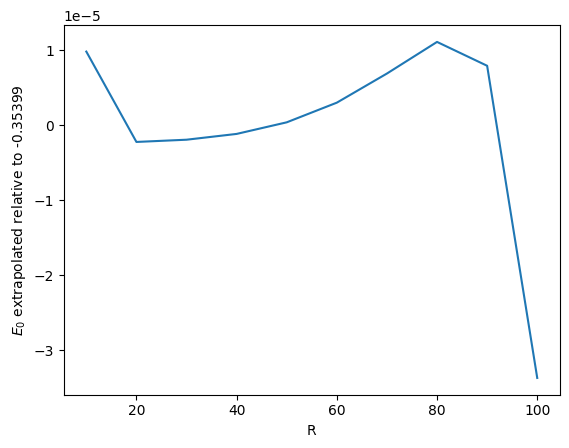

In [182]:
plt.plot(r, e0_pres-e0_pres.mean())
plt.xlabel('R')
plt.ylabel(fr'$E_0$ extrapolated relative to {e0_pres.mean():0.5f}')
plt.savefig('figures/E0_extrapolated.pdf', bbox_inches='tight')

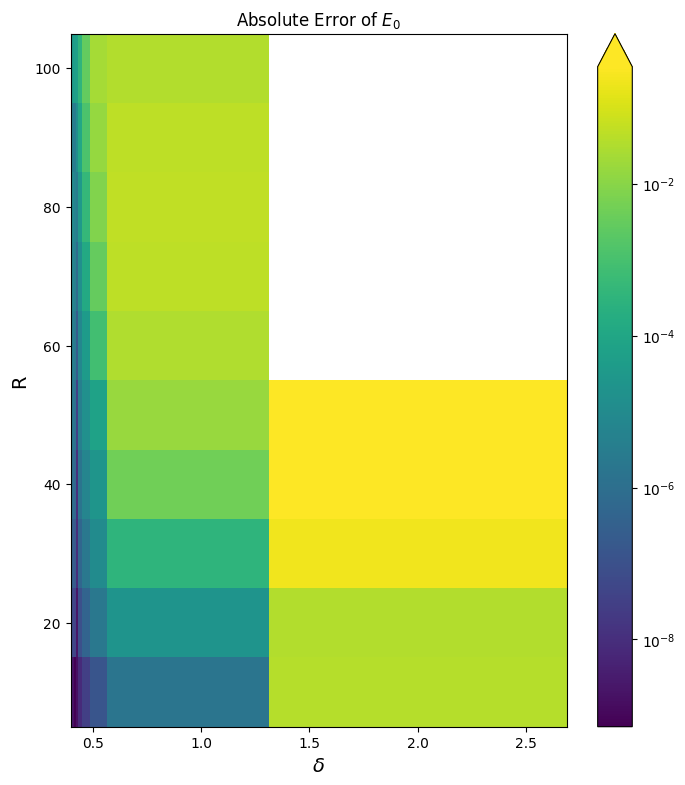

In [185]:
fig, ax = plt.subplots(1, 1, figsize=(8,9))

z = np.abs([e0[i,:]-e0_pres[i] for i in range(len(e0))])

pcm = ax.pcolormesh(2*r/m, r, z,
                    norm=colors.LogNorm(vmin=np.nanmin(z),
                                        vmax=np.nanmax(z)),
                    )

fig.colorbar(pcm, ax=ax, extend='max')

ax.set_xlabel(r'$\delta$', fontsize=14)
ax.set_ylabel('R', fontsize=14)

ax.set_title(r'Absolute Error of $E_0$')

fig.savefig('figures/abserr.pdf')

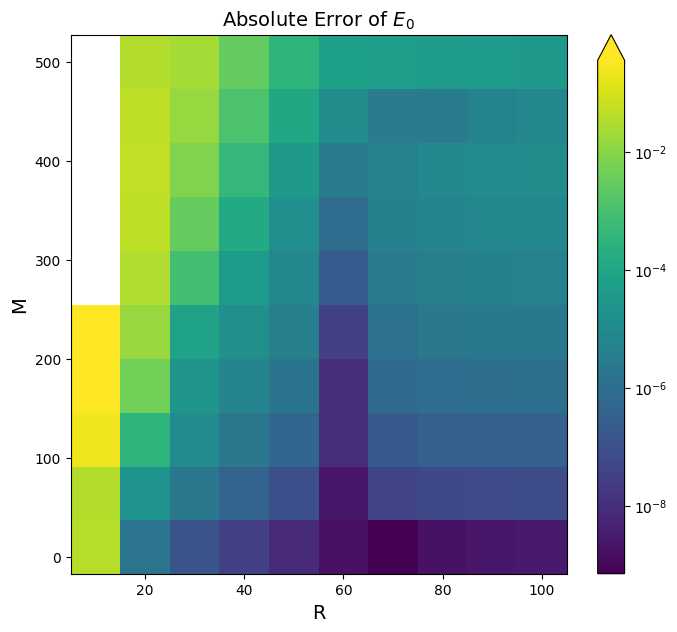

In [186]:
fig, ax = plt.subplots(1, 1, figsize=(8,7))

pcm = ax.pcolormesh(r, m, np.abs(z), norm=colors.LogNorm(vmin=np.nanmin(z),
                                        vmax=np.nanmax(z)))
fig.colorbar(pcm, ax=ax, extend='max')

ax.set_xlabel('R', fontsize=14)
ax.set_ylabel('M', fontsize=14)

ax.set_title(r'Absolute Error of $E_0$', fontsize=14)

fig.savefig('figures/abserr_rm.pdf')